<a href="https://colab.research.google.com/github/natehorner/learn_pt_02/blob/main/pt_vision_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install - once only

!pip install torchmetrics



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 15.3 MB/s eta 0:00:00


In [17]:
#common block - run once to prevent re-dwnload as debugging
import torch
from torch import nn
SEED_BASE = int("BADBEEF",16)
device = "cuda" if torch.cuda.is_available() else "cpu"

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


if(device == "cpu"):
  torch.manual_seed(SEED_BASE)
else:torch.cuda.manual_seed(SEED_BASE)

import torchmetrics
from torchmetrics import Accuracy

print(torch.__version__)
print(torchvision.__version__)


"""
from: https://pytorch.org/vision/stable/datasets.html

imagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=args.nThreads)
"""


train_data = datasets.FashionMNIST(
    root="data",#destination directory
    train=True, #training, not test
    download=True, #download yes
    transform=ToTensor(), #how output should be handled
    target_transform=None #how lables/targets should be handled
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)


2.1.0+cu118
0.16.0+cu118


In [18]:
#debug - understand whats going on with training data

#len(train_data),len(test_data)
#: (60000, 10000)

class_names = train_data.classes
#class_names
#: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
#:  'Sneaker', 'Bag', 'Ankle boot']

train_data.targets
#: tensor([9, 0, 0,  ..., 3, 0, 5])

train_data.targets
train_data.data #densor of all 6000 x 28 x 28 images


#image,label = train_data[0]

#image.shape
#: torch.Size([1, 28, 28])

#label
#: 9

#class_names = train_data.classes #...from above...
#class_names[label]
#: 'Ankle boot


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

Text(0.5, 1.0, 'Ankle boot')

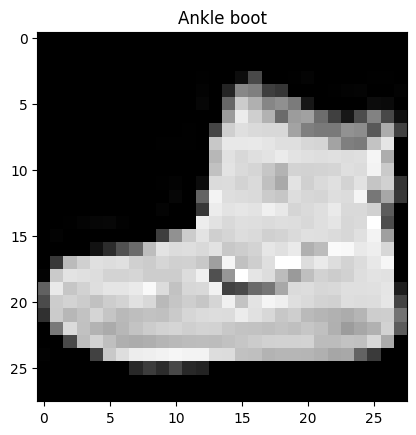

In [19]:
#debug - visualize the image data...

class_names = train_data.classes
image,label = train_data[0]
#image.shape
#: torch.Size([1, 28, 28])

plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])




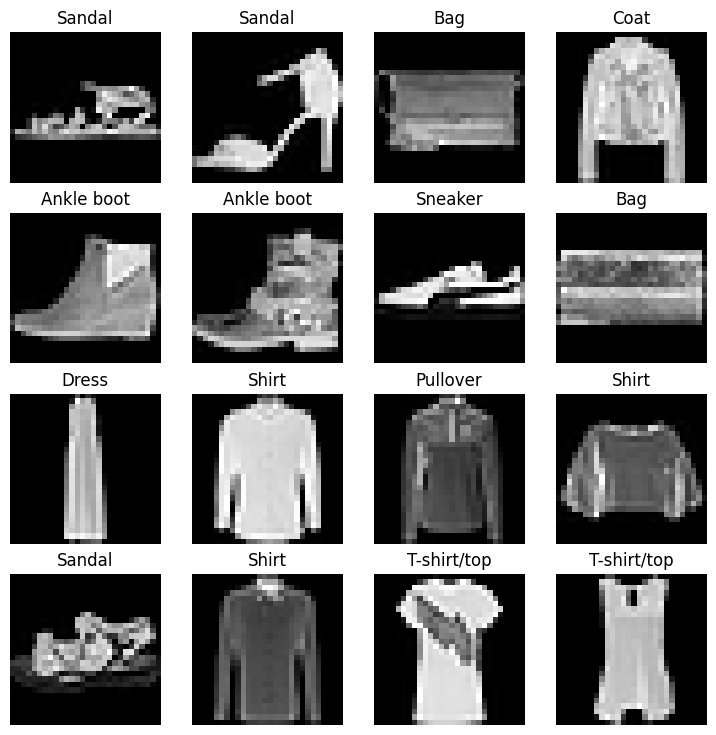

In [20]:
#plot 9 random images - seed is set above so it will change on re-run
class_names = train_data.classes
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1,rows*cols+1):
  random_idx=torch.randint(0,len(train_data),size=[1]).item()
  img,label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)



In [21]:


#break this down to batches of 32 each
BATCH_SIZE = 32

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) #shuffle makes it so that ordered
                                            # data sets don't matter



test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

#print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} total {len(train_data)}")
#print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} total {len(test_data)}")
#: Length of train_dataloader: 1875 batches of 32 total 60000
#: Length of test_dataloader: 313 batches of 32 total 10000



In [26]:

#start making a model!

IN_FEAT = 28*28 #based on input data - fashion database is 28x28 pixel images
HIDDEN_UNITS = 16
OUT_CLASSES = len(class_names)
LEARN_RATE = 0.1
EPOCHS = 3 #run through data set 1x

#define fashion model
class FashionMNISTModel0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),#flatten the 28x28 input to a vector
      nn.Linear(in_features=input_shape,  out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
      nn.ReLU()
    )

  def forward(self,x):
    return self.layer_stack(x)

torch.manual_seed(SEED_BASE)
model_fashion = FashionMNISTModel0(input_shape=IN_FEAT,
                                   hidden_units=HIDDEN_UNITS,
                                   output_shape=OUT_CLASSES
                                   ).to(device)


#random_x = torch.rand([1,1,28,28])
#model_fashion(random_x)
#: tensor([[-0.1270,  0.1232, -0.1482, -0.0283,  0.2149, -0.1326, -0.0536, -0.3630,
#:           0.4791, -0.0644]], grad_fn=<AddmmBackward0>)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model_fashion.parameters(),lr = LEARN_RATE)


#eval metric - use accuracy
acc_fn = Accuracy(task="MULTICLASS",num_classes=OUT_CLASSES).to(device)

"""
 at 15:46:51
"""

import tqdm
from tqdm.auto import tqdm
from timeit import default_timer as timer

train_time_start = timer()

for epoch in tqdm(range(EPOCHS)):
  print(f"Starting Epoch {epoch}:\n")

  #training batch loop
  train_loss = 0
  for batch, (X_train,y_train) in enumerate(train_dataloader):
    #data comes in data,label tuple - X is data, y is label

    #enable training mode
    model_fashion.train()

    X_train = X_train.to(device)
    y_train = y_train.to(device)

    #forward pass - make predictions using the model for this batch
    y_pred = model_fashion(X_train)

    #calculate loss per batch
    train_batch_loss = loss_fn(y_pred,y_train)
    train_loss += train_batch_loss

    #zero gradient the optimizer
    opt.zero_grad()

    #calculate model update
    train_batch_loss.backward()

    #step the optimizer, update the model
    opt.step()

    if batch % 500 == 0:
      print(f"finished batch {batch}, {batch*len(X_train)}/{len(train_dataloader.dataset)} samples")

  #end_loop batch

  train_loss /= len(train_dataloader) #scale to number of batches


  #test batch training loop
  test_loss = 0
  test_acc = 0

  model_fashion.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:

      X_test = X_test.to(device)
      y_test = y_test.to(device)

      #make predictions
      y_test_pred = model_fashion(X_test)

      #loss calc - don't need to get batch loss because not used to train
      test_loss += loss_fn(y_test_pred,y_test)

      test_acc += acc_fn(y_test_pred.argmax(dim=1),y_test)

  #end inference_mode()

  #average loss, average accuracy
  test_loss = test_loss/len(test_dataloader)
  test_acc = test_acc/len(test_dataloader)

  print(f"Epoch: {epoch}, Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f} Test Acc: {test_acc:.2f}%")


#end_loop epoch

train_time_end = timer()



  0%|          | 0/3 [00:00<?, ?it/s]

Starting Epoch 0:

finished batch 0, 0/60000 samples
finished batch 500, 16000/60000 samples
finished batch 1000, 32000/60000 samples
finished batch 1500, 48000/60000 samples
Epoch: 0, Train Loss: 0.77248, Test Loss: 0.53726 Test Acc: 0.82%
Starting Epoch 1:

finished batch 0, 0/60000 samples
finished batch 500, 16000/60000 samples
finished batch 1000, 32000/60000 samples
finished batch 1500, 48000/60000 samples
Epoch: 1, Train Loss: 0.47020, Test Loss: 0.46326 Test Acc: 0.83%
Starting Epoch 2:

finished batch 0, 0/60000 samples
finished batch 500, 16000/60000 samples
finished batch 1000, 32000/60000 samples
finished batch 1500, 48000/60000 samples
Epoch: 2, Train Loss: 0.43284, Test Loss: 0.45582 Test Acc: 0.83%


In [24]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn):
  """Returns a dictionary containing results of model predicting data loader"""
  loss,acc = 0,0

  model.eval()
  with torch.inference_mode():
    for X_data,y_labels in tqdm(data_loader):

      X_data = X_data.to(device)
      y_labels = y_labels.to(device)

      #make prediction
      y_pred = model(X_data)

      #accumulate loss
      loss += loss_fn(y_pred,y_labels)
      acc += acc_fn(y_pred.argmax(dim=1),y_labels)
    #end batch loop

    #scale loss and acc to be per batch
    loss = loss/len(data_loader)
    acc = acc/len(data_loader)

    return {"model_name":model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc":acc}
  #end inference_mode
#end eval_model()

model_0_results = eval_model(model=model_fashion,data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             acc_fn = acc_fn)
model_0_results


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModel0',
 'model_loss': 0.5372635722160339,
 'model_acc': tensor(0.8170, device='cuda:0')}